In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pickle as pkl
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import Image
import pandas as pd
from tqdm import tqdm

# from causallearn.search.ConstraintBased.FCI import fci
# from causallearn.search.ConstraintBased.PC import pc
# from causallearn.utils.GraphUtils import GraphUtils
# from causallearn.graph.GraphClass import CausalGraph
# from causallearn.utils.DAG2CPDAG import dag2cpdag
# from causallearn.graph.Edge import Edge
# from causallearn.graph.Endpoint import Endpoint
# from causallearn.graph.SHD import SHD

import io
import matplotlib.image as mpimg

import seaborn as sns

In [7]:
galtypes = ['ell','len','spr']
typename = {'ell':'E','len':'S0','spr':'S'}

labels_list = [r'$\text{M}_\bullet$',r'$\sigma_0$', r'$\text{R}_e$', r'$\Sigma_e$',
       r'$\text{M}^*$', r'$\text{sSFR}$', r'$\text{W}_2-\text{W}_3$']
labels_list_fci = ['M_bh','sigma_0', 'R_e', 'Sigma_e','M*', 'sSFR', 'W_2-W_3']

folder = '/data/zj448/causal/exact_posteriors'


In [5]:
def decompress_dag(dag, num_nodes):
    # decompress
    uncompressed=np.unpackbits(dag, axis=1, count=num_nodes**2).reshape(-1, num_nodes, num_nodes)
    return uncompressed

def weighted_average(dags, p):
    # Ensure weights are shaped for broadcasting
    weights = p[:, None, None]
    # Calculate weighted sum
    weighted_sum = np.sum(dags * weights, axis=0)
    # Sum of weights
    sum_weights = p.sum()
    # Calculate weighted average
    weighted_average = weighted_sum / sum_weights
    return weighted_average


## from dag-gflownet
def expected_shd(posterior, ground_truth):
    """Compute the Expected Structural Hamming Distance.

    This function computes the Expected SHD between a posterior approximation
    given as a collection of samples from the posterior, and the ground-truth
    graph used in the original data generation process.

    Parameters
    ----------
    posterior : np.ndarray instance
        Posterior approximation. The array must have size `(B, N, N)`, where `B`
        is the number of sample graphs from the posterior approximation, and `N`
        is the number of variables in the graphs.

    ground_truth : np.ndarray instance
        Adjacency matrix of the ground-truth graph. The array must have size
        `(N, N)`, where `N` is the number of variables in the graph.

    Returns
    -------
    e_shd : float
        The Expected SHD.
    """
    # Compute the pairwise differences
    diff = np.abs(posterior - np.expand_dims(ground_truth, axis=0))
    diff = diff + diff.transpose((0, 2, 1))

    # Ignore double edges
    diff = np.minimum(diff, 1)
    shds = np.sum(diff, axis=(1, 2)) / 2

    #return np.mean(shds)
    return shds


def plot_top_dags(dags, p, num=10, labels_list=labels_list, render_latex=False, save: str |None = None):
    # Render LaTeX to an image
    def render_latex_to_file(str, filepath):
        fig = plt.figure()
        fig = plt.figure(figsize=(0.01, 0.01))
        fig.text(0.5, 0.5, str, fontsize='xx-large', ha='center', va='center')
        plt.axis('off')
        plt.savefig(filepath, bbox_inches='tight')
        plt.close(fig)
    
    if render_latex:
        for i,string in enumerate(labels_list):
            render_latex_to_file(string,'plots/label'+str(i)+'.png')

    for i, sample in enumerate(dags[:num]):
        graph = nx.from_numpy_array(sample, create_using=nx.DiGraph)

        
        # Apply labels to the graph
        for j,node in enumerate(graph.nodes()):
            graph.nodes[node]['image'] = 'plots/label'+str(j)+'.png'
            graph.nodes[node]['label'] = ''

        
        gviz = nx.nx_agraph.to_agraph(graph)

        gviz.graph_attr['label'] = format(p[i]*100,'.3g')+'%'
        gviz.graph_attr['labelloc'] = 't'  # Top of the graph
        gviz.graph_attr['labeljust'] = 'l'  # Right-justified
        gviz.graph_attr['fontsize'] = 15
        gviz.graph_attr['fontname'] = 'Calibri'
        gviz.graph_attr['dpi'] = 100


        # Render the graph to a PNG image and display it inline
        if save is None:
            output_path = 'plots/graph.png'
        else:
            output_path = 'plots/'+save+'_top'+str(i+1)+'.png'
        gviz.draw(output_path, prog='dot', format='png')  # Use 'dot' or another Graphviz layout engine

        

        #print(counts[i],'/',samplesize,'(',counts[i]/samplesize*100,'%)')
        # Display the image
        display(Image(output_path))


def marginal_matrix(dags, p, labels_list=labels_list,typename: str |None = None,plot_path=False):
    # edge marginals
    confusion = weighted_average(dags, p)

    #sns.heatmap(confusion, cmap='gray', annot=confusion,fmt='.3f')
    sns.heatmap(confusion, cmap='gray', annot=confusion)
    if typename is not None:
        plt.title(typename)
    plt.xlabel('Child')
    plt.ylabel('Parent')
    plt.xticks(np.arange(len(labels_list))+0.5, labels_list, rotation=60)
    plt.yticks(np.arange(len(labels_list))+0.5, labels_list, rotation=0)
    plt.show()

    # path marginals
    # if plot_path:
    #     transitive_closure = np.zeros(dags.shape)
    #     for i in range(dags.shape[0]):
    #         # get transitive closure of the graph
    #         G = nx.from_numpy_array(dags[i], create_using=nx.DiGraph)
    #         # Compute the transitive closure of the graph
    #         TC = nx.transitive_closure(G)

    #         # Convert the transitive closure graph back to a numpy array
    #         tc_adj_matrix = nx.to_numpy_array(TC, dtype=int)

    #         transitive_closure[i] = tc_adj_matrix
        
    #     confusion = np.average(transitive_closure, axis=0, weights=p)
    #     sns.heatmap(confusion, cmap='gray', annot=confusion)
    #     if typename is not None:
    #         plt.title(typename)
    #     plt.xlabel('Descendant')
    #     plt.ylabel('Ancestor')
    #     plt.xticks(np.arange(len(labels_list))+0.5, labels_list, rotation=60)
    #     plt.yticks(np.arange(len(labels_list))+0.5, labels_list, rotation=0)
    #     plt.show()

ell
calculating probabilities
Sorting
Calculating SHDs
len
calculating probabilities
Sorting
Calculating SHDs
spr
calculating probabilities
Sorting
Calculating SHDs


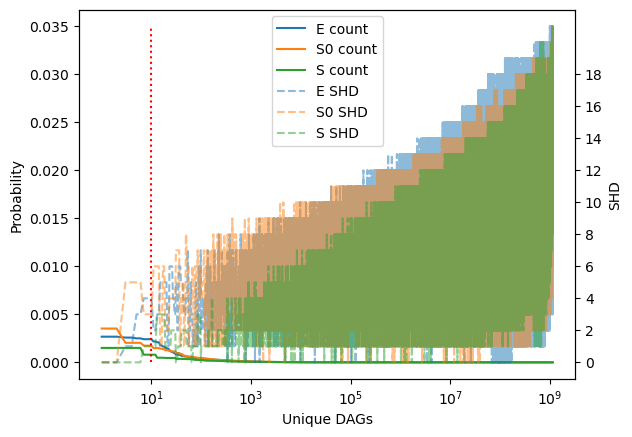

In [8]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

p={}
shds={}
order={}

folder = '/data/zj448/causal/exact_posteriors'
dags = np.load(folder+'/dags_7.npy')
dags = decompress_dag(dags, 7)


for galtype in galtypes:
    print(galtype)
    # load bge scores
    bge = np.load(folder+'/bge_'+galtype+'.npy')
    # turn scores into probabilities, and normalize
    print('calculating probabilities')
    bge = np.exp(bge)
    p[galtype] = bge/np.sum(bge)

    print('Sorting')
    # sort probabilities
    order[galtype] = np.argsort(-p[galtype])
    p[galtype] = p[galtype][order[galtype]]

    # calculate shds
    print('Calculating SHDs')
    dags_ = dags[order[galtype]]
    shds[galtype] = expected_shd(dags_, dags_[0])

    # plot count of unique samples on using the left y axis, and the shd on the right y axis
    ax1.plot(np.arange(len(p[galtype]))+1, p[galtype],label=typename[galtype]+' count')
    ax2.plot(np.arange(len(p[galtype]))+1, shds[galtype], alpha=0.5,ls='--',label=typename[galtype]+' SHD')


ax1.set_xlabel('Unique DAGs')
ax1.set_ylabel('Probability')
ax1.set_xscale('log')
ax2.set_ylabel('SHD')
ax2.set_yticks(np.arange(0, 20, 2))
ax1.vlines(10,0,0.035,linestyles='dotted',colors='r')

# Combine the legends of ax1 and ax2
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2,loc='upper center')




In [18]:
# save p, shds, order in folder, with pkl
pkl.dump(p, open(folder+'/p.pkl', 'wb'))
pkl.dump(shds, open(folder+'/shds.pkl', 'wb'))
pkl.dump(order, open(folder+'/order.pkl', 'wb'))

In [7]:
# load p, shds, order from folder
folder = '/data/zj448/causal/exact_posteriors'
p = pkl.load(open(folder+'/p.pkl', 'rb'))
shds = pkl.load(open(folder+'/shds.pkl', 'rb'))
order = pkl.load(open(folder+'/order.pkl', 'rb'))
# load dags
dags = np.load(folder+'/dags_7.npy')
dags = decompress_dag(dags, 7)

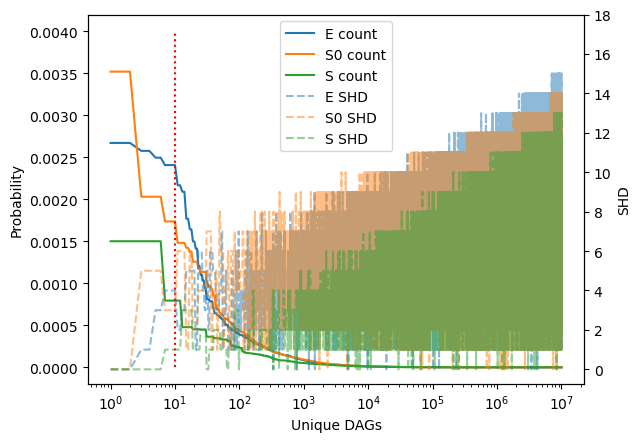

In [16]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

plt_num = 10000000
for galtype in galtypes:
    # plot count of unique samples on using the left y axis, and the shd on the right y axis
    ax1.plot(np.arange(len(p[galtype][:plt_num]))+1, p[galtype][:plt_num],label=typename[galtype]+' count')
    ax2.plot(np.arange(len(p[galtype][:plt_num]))+1, shds[galtype][:plt_num], alpha=0.5,ls='--',label=typename[galtype]+' SHD')


ax1.set_xlabel('Unique DAGs')
ax1.set_ylabel('Probability')
ax1.set_xscale('log')
ax2.set_ylabel('SHD')
ax2.set_yticks(np.arange(0, 20, 2))
ax1.vlines(10,0,0.004,linestyles='dotted',colors='r')

# Combine the legends of ax1 and ax2
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2,loc='upper center')


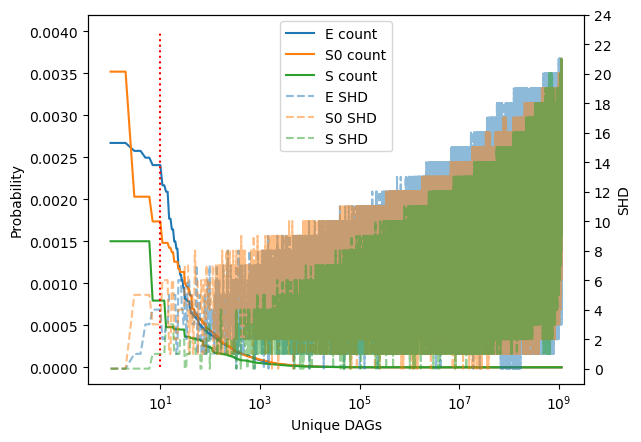

In [15]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

for galtype in galtypes:
    # plot count of unique samples on using the left y axis, and the shd on the right y axis
    ax1.plot(np.arange(len(p[galtype]))+1, p[galtype],label=typename[galtype]+' count')
    ax2.plot(np.arange(len(p[galtype]))+1, shds[galtype], alpha=0.5,ls='--',label=typename[galtype]+' SHD')


ax1.set_xlabel('Unique DAGs')
ax1.set_ylabel('Probability')
ax1.set_xscale('log')
ax2.set_ylabel('SHD')
ax2.set_yticks(np.arange(0, 26, 2))
ax1.vlines(10,0,0.004,linestyles='dotted',colors='r')

# Combine the legends of ax1 and ax2
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2,loc='upper center')

E


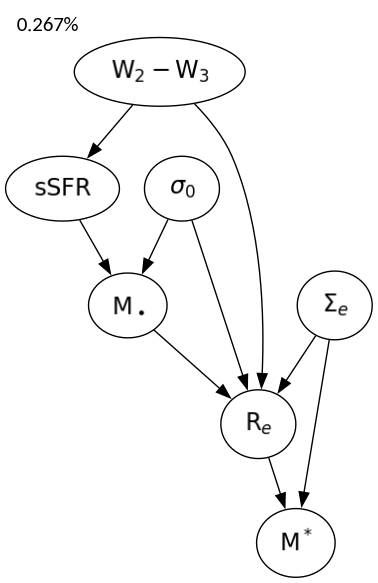

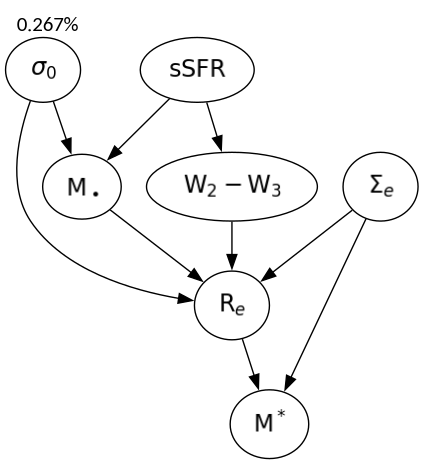

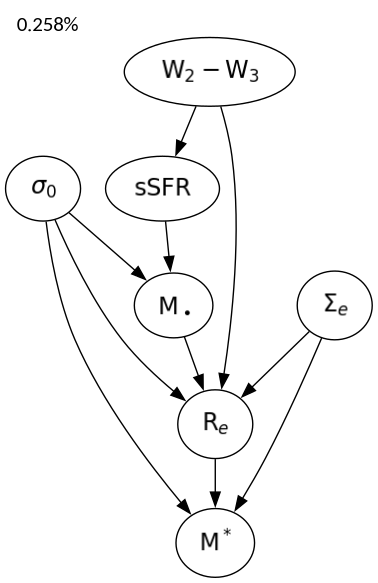

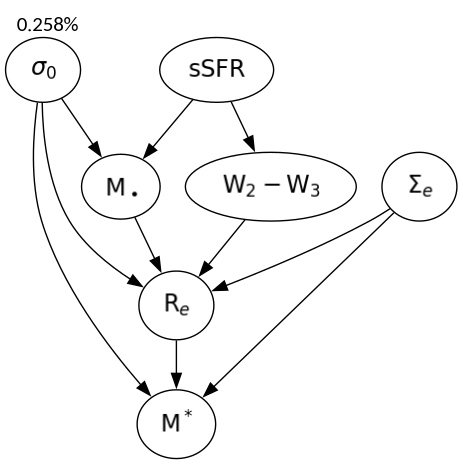

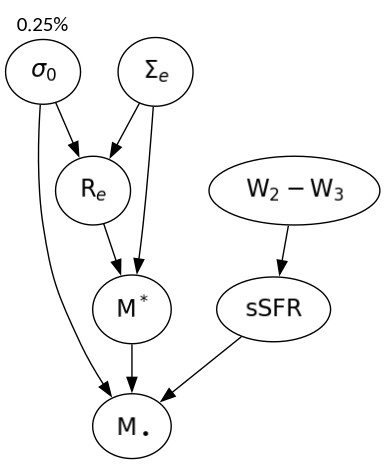

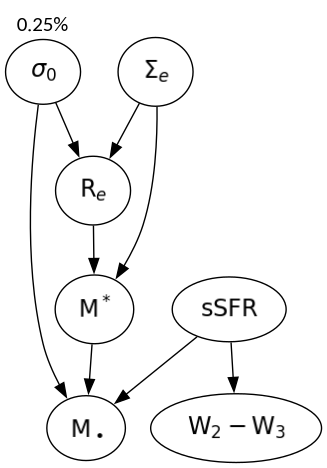

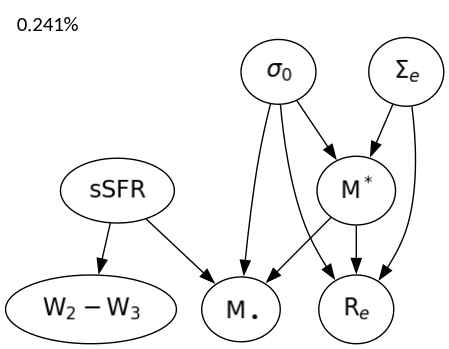

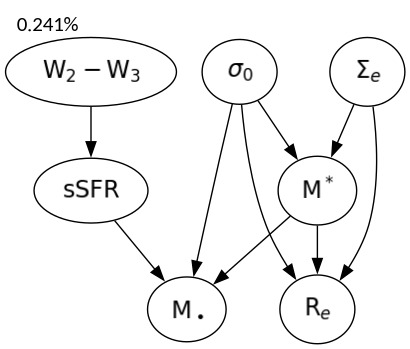

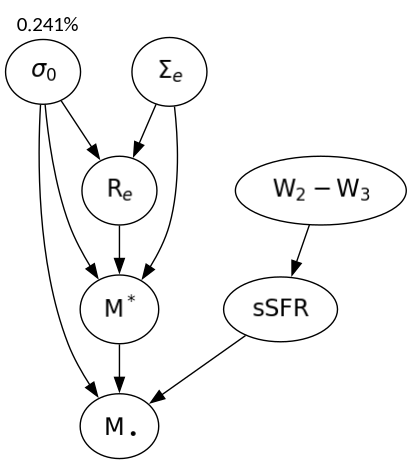

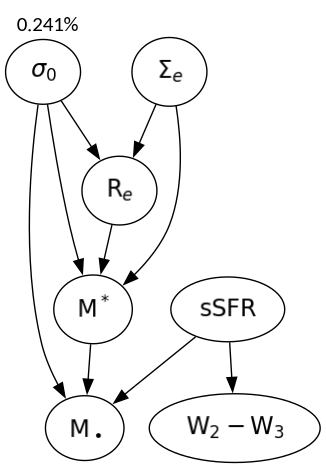

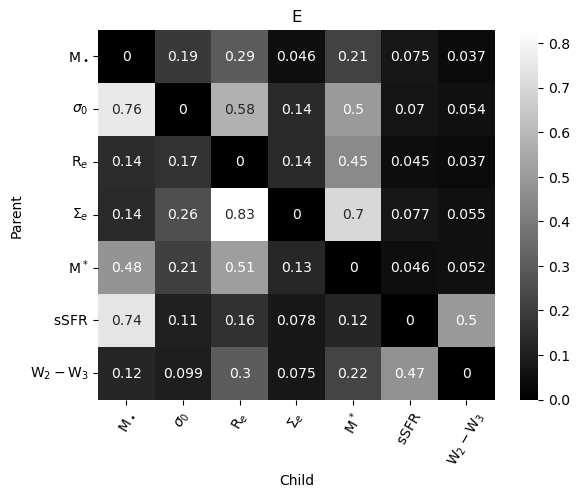

S0


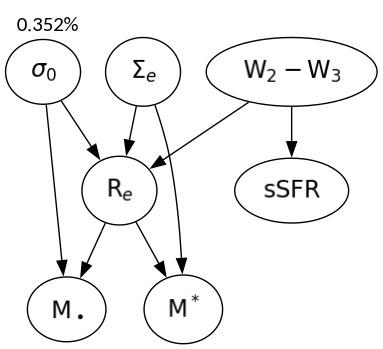

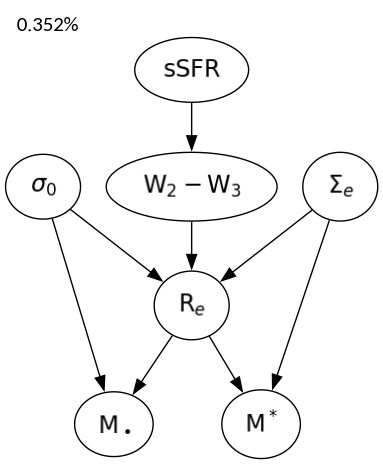

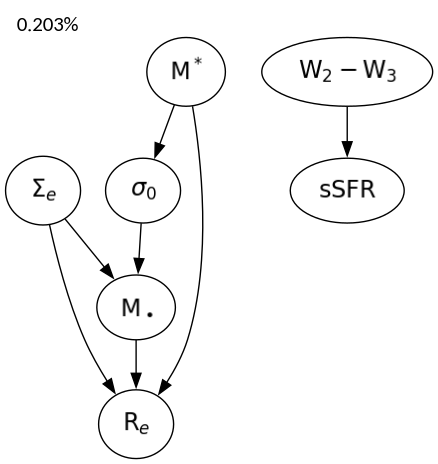

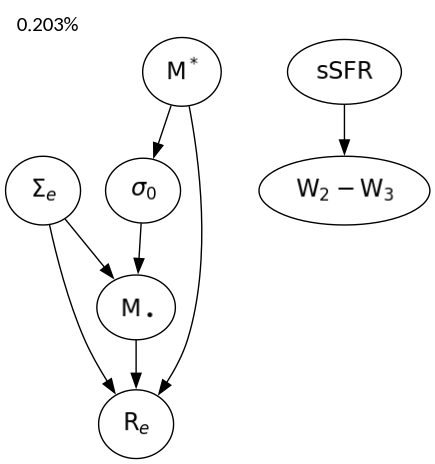

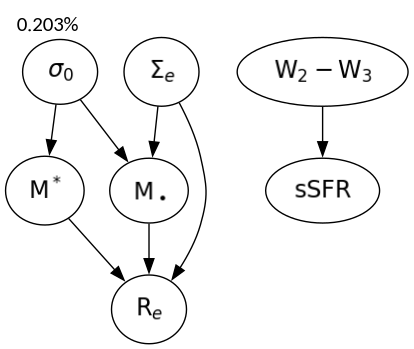

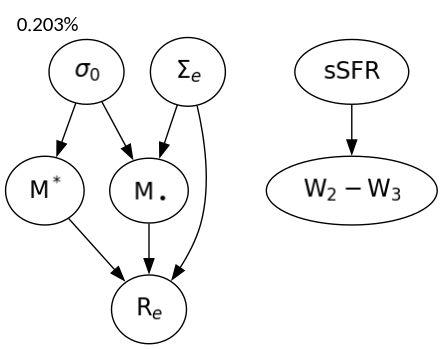

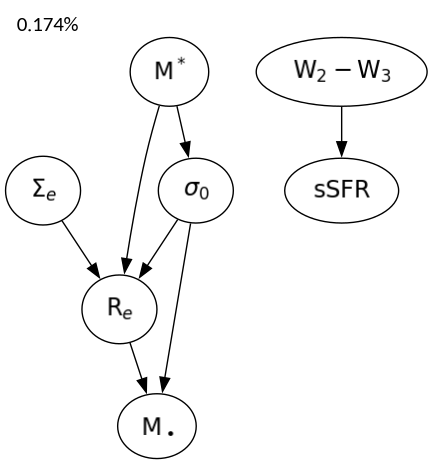

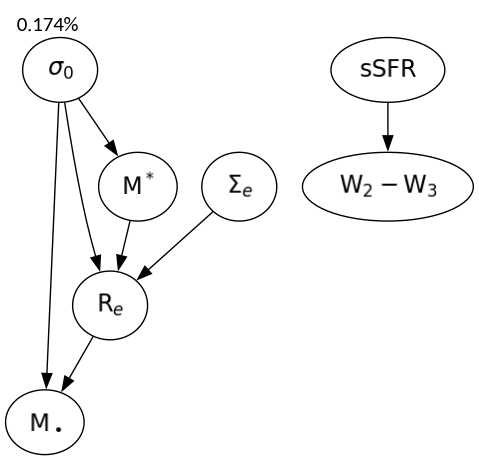

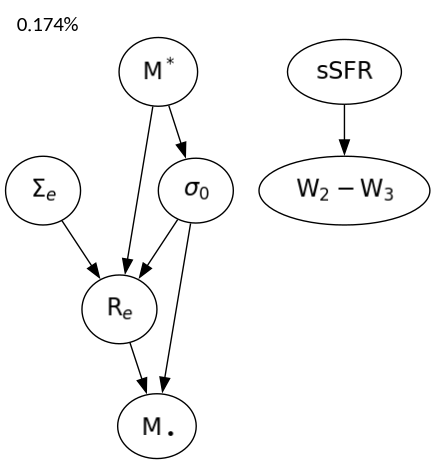

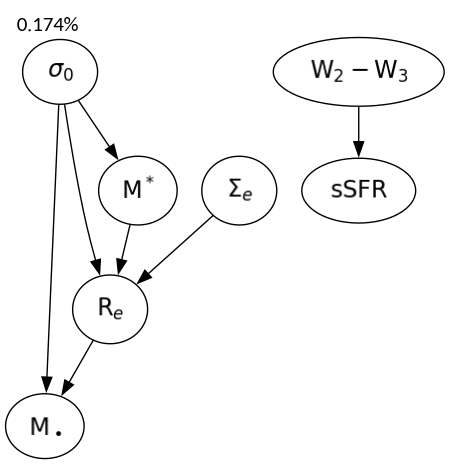

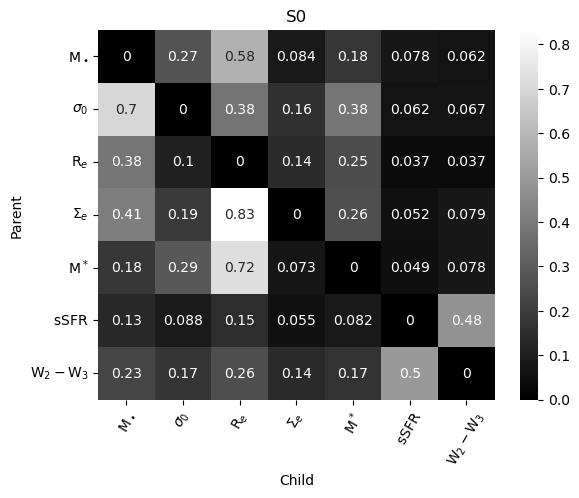

S


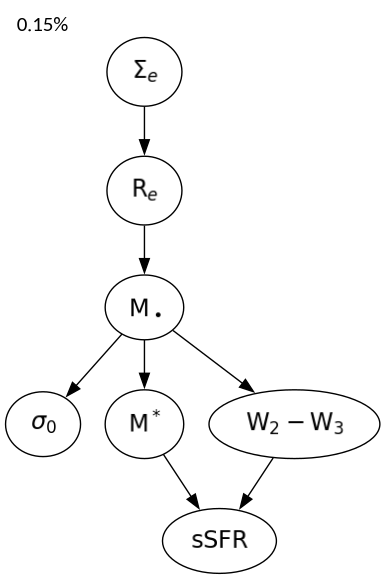

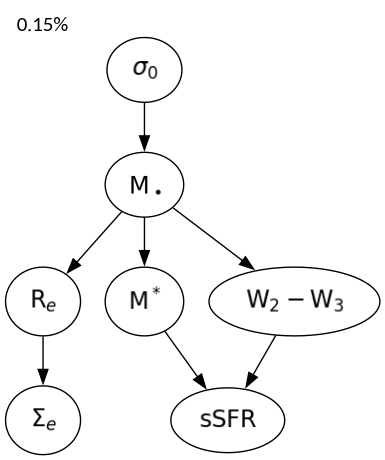

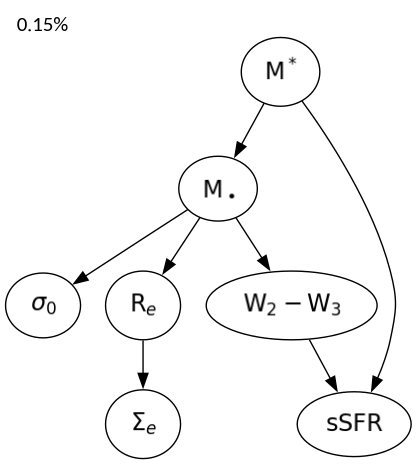

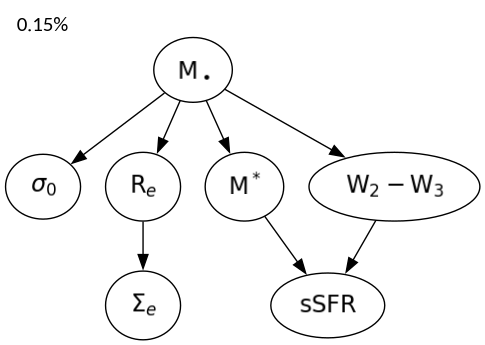

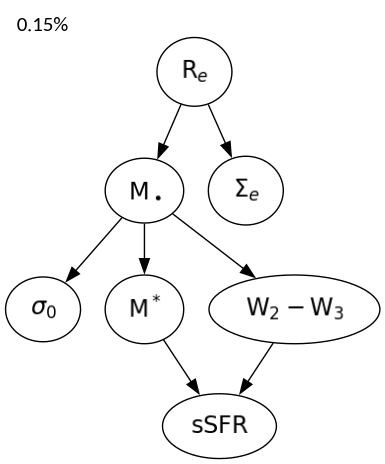

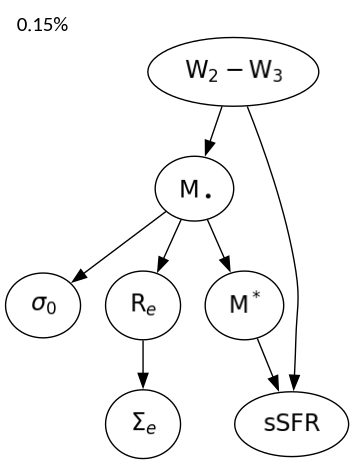

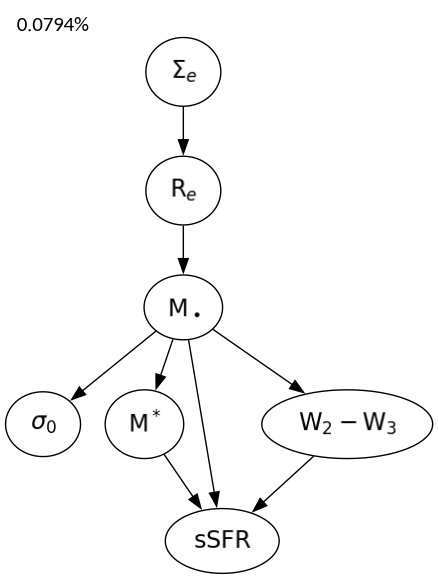

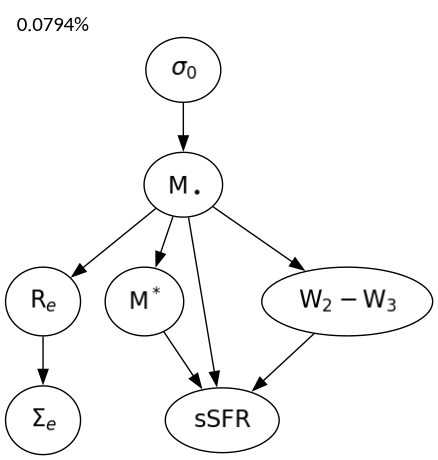

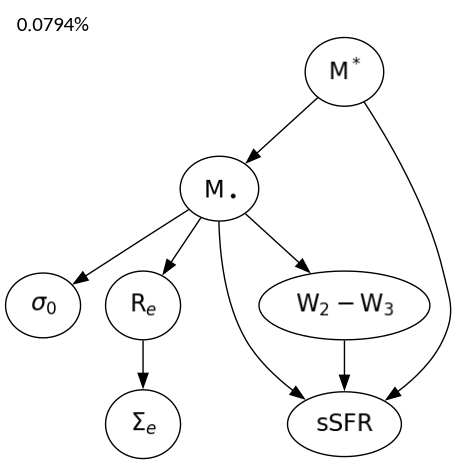

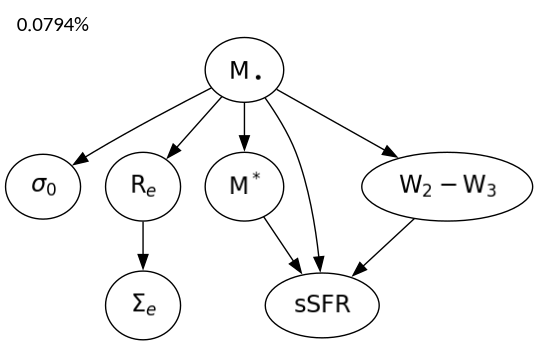

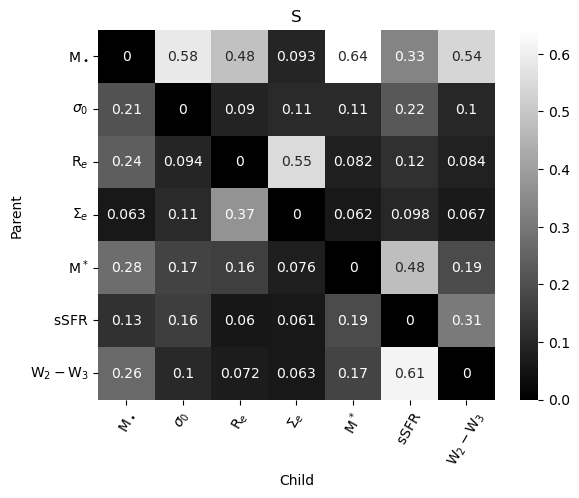

In [14]:
for galtype in galtypes:
    print(typename[galtype])
    print('===================================================')
    dags_ = dags[order[galtype]]
    plot_top_dags(dags_, p[galtype], num=10, save=galtype, render_latex=False)
    marginal_matrix(dags_, p[galtype], typename=typename[galtype],plot_path=False)
    print('===================================================')

E


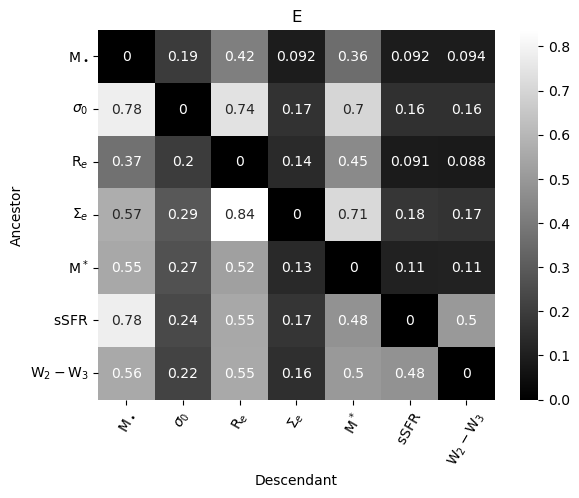

S0


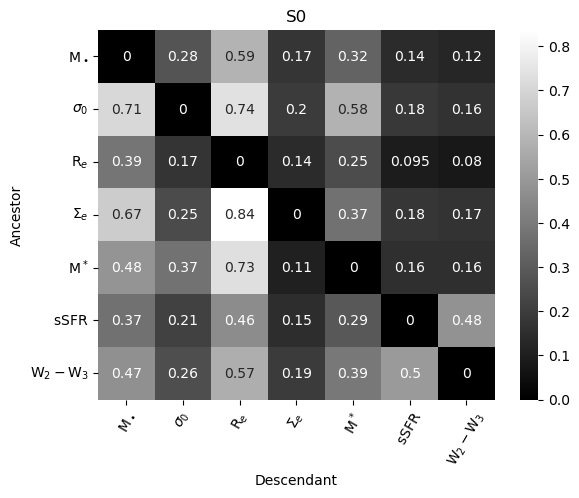

S


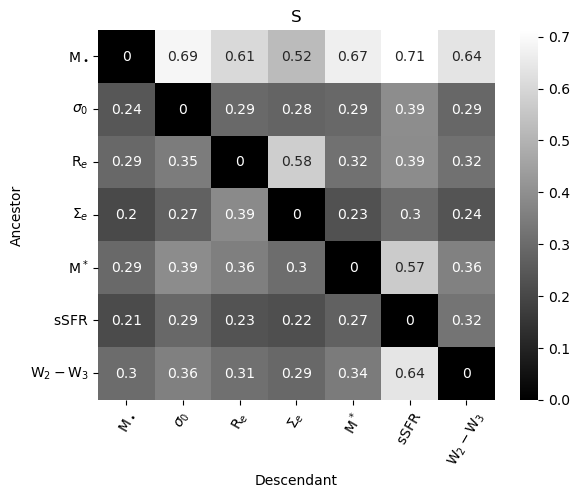

In [9]:
# path marginals
TC = np.load('/data/zj448/causal/exact_posteriors/TC_7.npy')
TC = decompress_dag(TC, 7)
for galtype in galtypes:
    print(typename[galtype])
    print('===================================================')
    bge = np.load(folder+'/bge_'+galtype+'.npy')
    bge = np.exp(bge)
    prob = bge/np.sum(bge)

    # perform weighted average
    confusion = weighted_average(TC, prob)
    sns.heatmap(confusion, cmap='gray', annot=confusion)
    plt.title(typename[galtype])
    plt.xlabel('Descendant')
    plt.ylabel('Ancestor')
    plt.xticks(np.arange(len(labels_list))+0.5, labels_list, rotation=60)
    plt.yticks(np.arange(len(labels_list))+0.5, labels_list, rotation=0)
    plt.show()
    print('===================================================')




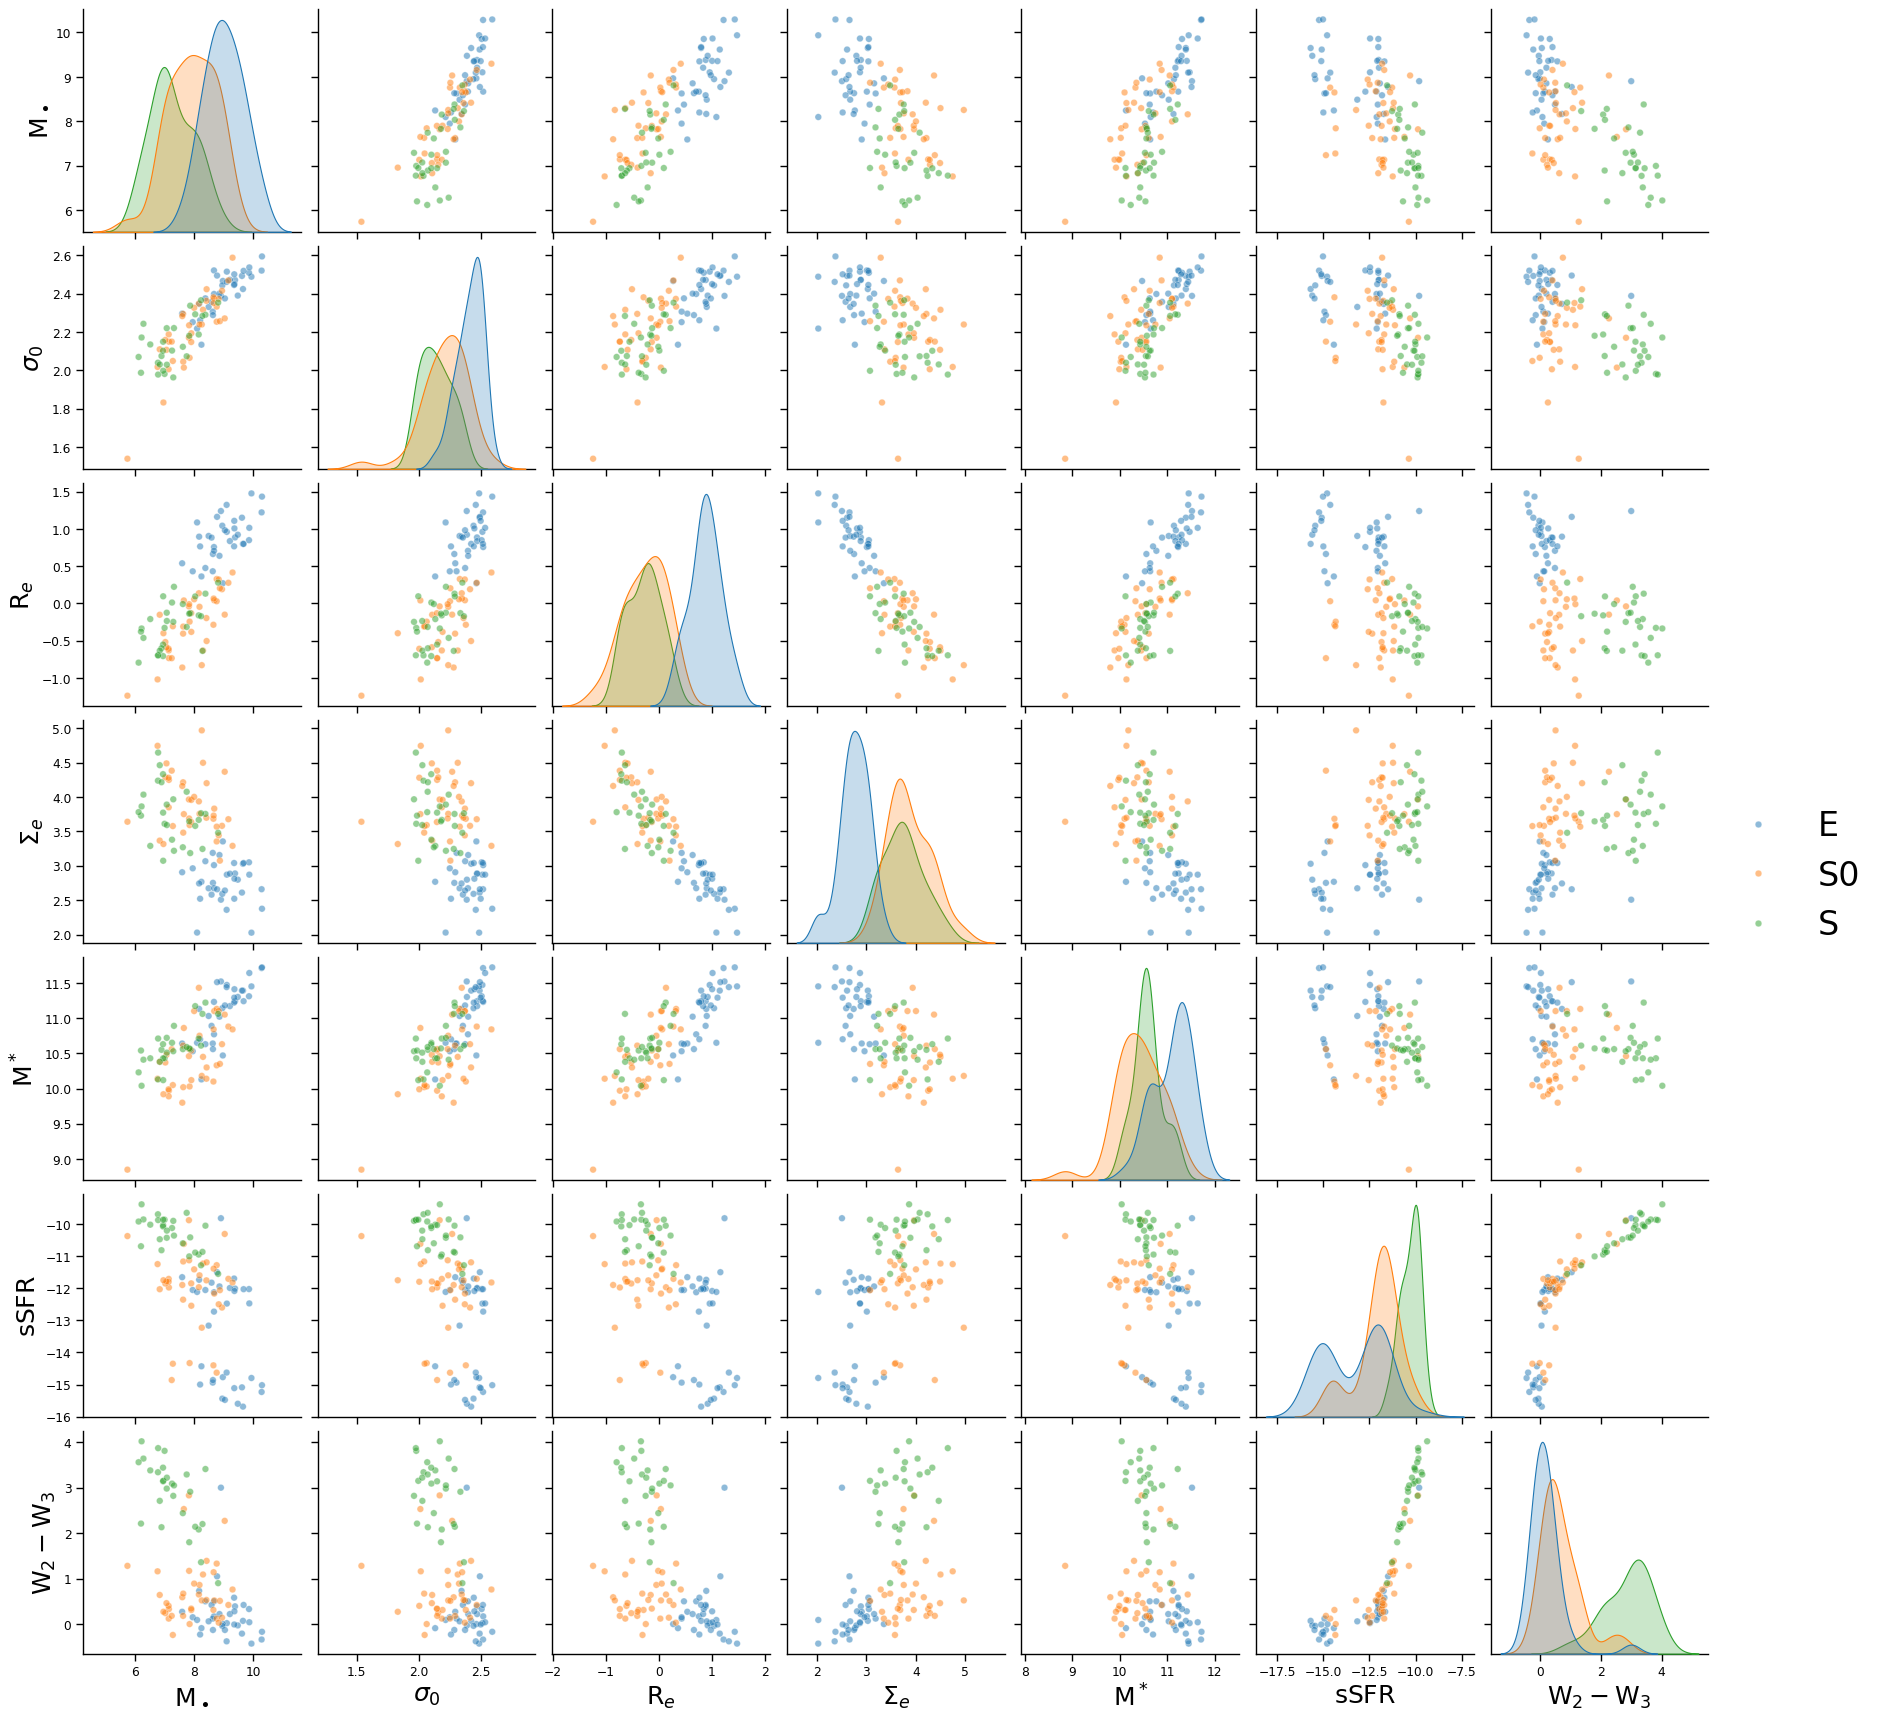

In [10]:
# plot the pairplot of each galtype data located at 'causal_BH_'+galtype+'.csv'on one pairplot, use different color for each galtype, and use labels_list for the labels
for galtype in galtypes:
    df = pd.read_csv('R_e_data/causal_BH_'+galtype+'.csv')
    df['galtype'] = typename[galtype]
    if galtype == 'ell':
        df_all = df
    else:
        df_all = pd.concat([df_all,df])
# rename column names to labels_list
df_all.columns = labels_list + [' ']
sns.set_context("paper", rc={"axes.labelsize":18,"legend.fontsize":24})
sns.pairplot(df_all, hue=' ', diag_kind='kde', plot_kws={'alpha':0.5})